# Quantitative Trading Strategy # 3

## Return Predictions from Trade Flow (in Crypto Assets)

## Sections
1. Objectives
2. Preliminaries
3. Flow Trade Strategies
* Section A: BTC-USD
* Section B: ETH-USD
* Section C: ETH-BTC
4. Conclusions

## 1. Objectives

The broad objective of this analysis is to analyze trading opportunities arising out of Flow volumes. The underlying principle here is that some market particiapnts may have relevant information regarding the expected movement of the underlying asset exchange rate. When such participants place trades in the market, we start seeing directional volumes start building up. For example, we might seeing much higher volumes of seller initiated trades than buyer initiated trades in a 1 minute window indicating an opportunity to profitably sell.

Thus we define a Flow parameter as:

$F^{\tau}_{t} = V^{B}_{(t - \tau,t)} - V^{S}_{(t - \tau,t)}$

where 

$V^{B}_{(t - \tau,t)}$ is the Buy Volume in the last $\tau$ seconds and <br><br>
$V^{S}_{(t - \tau,t)}$ is the Sell Volume in the last $\tau$ seconds

Based on this Flow data, we propose to initate our buy or sell actions. Specifically, we regress the Flow volume on actual realized returns in a training data set and then test this strategy for getting actual returns from trading on Flow.

We use three parameters here,:

1. $\tau$ : is the lookback period that we observe the Flow volumes for
2. $T$ : is the amount of time we hold our position before selling in the market for a profit expectation
3. $j$: Based on the results from our regression anlysis, we would attempt to trade whenever $j < |r_i|$. This would put a threshold on the number of times we are actively trading. Here we try to find "realistic" proportion of total trades that we can inject our trades on to be between about 1% and 5%. 


Empirically, such Flow Trade strategies have been quite popular in the Cryptocurrency markets. We would try exploring this Flow Trade strategy for three asset pairs:

(a). BTC-USD : Bitcoin-US Dollar Exchange rate <br>
(b). ETH-USD : Etherium-US Dollar Exchange rate <br>
(c). ETH-BTC : Etherium-Bitcoin Exchange rate <br>

We use the actual trades data from April 2021 to build and test the strategy. Some of the <b> assumptions </b> used are:

1. We could enter the market at any given time at the existing exchange rate. Here we model entering the market at exact trade time stamps to mimic correct entry price.
2. We exit each trade exactly after holding the position for $T$ seconds. We use the Asset trading book's mid-price for the actual exit price approximation.



## 2. Preliminaries
Here we define the functions and Python libraries used in this analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import nasdaqdatalink
import seaborn as sns
import statsmodels.api as sm
from collections import defaultdict
sns.color_palette("mako", as_cmap=True)

import plotnine as p9
plt.rcParams["figure.figsize"] = [15,6]

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
def summaryStats(df):
    
    summary = pd.DataFrame(index = df.columns)
    
    summary['Period Return'] = df.mean()*len(df)
    summary['Volatility'] = df.std()*np.sqrt(len(df))
    summary['Sharpe Ratio'] = summary['Period Return']/summary['Volatility']    
    summary['Skewness'] = df.skew()
    summary['min return'] = df.min()
    summary['Expected Shortfall (95% VaR)'] = df[df < df.quantile(0.05)].mean()
    
    levels = (1+df).cumprod()
    high = levels.cummax()
    drawdown = (levels - high)/high
    
    summary['Maximum Drawdown'] = drawdown.min()
    

    return summary

In [3]:
def cummulativeReturnsPlot(strategy,jTry,title):
    
    fig, ax = plt.subplots(2, 2, figsize=(14, 8),sharey = True)
    color = ['b','g','r','c']

    returns = pd.DataFrame(index=strategy.index)

    for i,j in enumerate(jTry):
        strategy['trade'] = strategy['predictedReturn'].apply(tradeInit,args = [j])
        strategy['StratReturn'] = strategy['logReturn']*strategy['trade']  
        returns['For j = '+str(j)] = strategy['StratReturn']

        idx = (i//2,i%2)
        ax[idx].plot(strategy['StratReturn'].cumsum(),color=color[i])
        ax[idx].tick_params(labelrotation=45)
        ax[idx].set(title="j = "+str(j),ylabel = 'Return on $1 Investment')

    plt.suptitle(title,fontsize=20) 
    plt.tight_layout()
    plt.show()
    
    return returns


In [4]:
def tradeInit(x,j):
    if x > j:return 1
    elif x < -j: return -1
    else: return 0

In [5]:
file_name = ['book_narrow_BTC-USD_2021.delim','book_narrow_ETH-BTC_2021.delim','book_narrow_ETH-USD_2021.delim', \
            'trades_narrow_BTC-USD_2021.delim','trades_narrow_ETH-BTC_2021.delim','trades_narrow_ETH-USD_2021.delim']
data = {}
for file in file_name:
    file_data = pd.read_csv(file+'.gz', sep='\t')
    data[file.split('.')[0]] = file_data

In [6]:
data.keys()

dict_keys(['book_narrow_BTC-USD_2021', 'book_narrow_ETH-BTC_2021', 'book_narrow_ETH-USD_2021', 'trades_narrow_BTC-USD_2021', 'trades_narrow_ETH-BTC_2021', 'trades_narrow_ETH-USD_2021'])

In [7]:
def analyzeTrades(book,trades,tauSeconds=30,TSeconds=10):
    
    '''
    Performs Regression Analysis on 20% Training Data set of Trades for given tau and T
    '''
    
    book = data[book]\
                .drop(columns='timestamp_utc_nanoseconds')\
                .set_index('received_utc_nanoseconds').sort_index()

    trades = data[trades]\
                .drop(columns='timestamp_utc_nanoseconds')\
                .set_index('received_utc_nanoseconds').sort_index()

    trades.index = pd.to_datetime(trades.index)

    book.index = pd.to_datetime(book.index)

    trades['Side'] = np.where(trades['Side']>0,1,-1)
    book = book[['Mid']]

    tauSeconds = tauSeconds
    tau = pd.to_timedelta(tauSeconds,'s')

    tradeFlow = trades.pivot(columns='Side')['SizeBillionths']\
                                .groupby(trades.index).agg({-1:'sum',1:'sum'})\
                                .shift().rolling(tau).sum().rename(columns = {-1:'SellFlow',1:'BuyFlow'})


    tradeFlow['Flow'] = tradeFlow['BuyFlow'].fillna(0) - tradeFlow['SellFlow'].fillna(0)
    tradeFlow = tradeFlow.drop(columns=['SellFlow','BuyFlow'])

    tradeFlow = tradeFlow.merge(trades['PriceMillionths'],how='left',left_index=True,right_index=True)

    TSeconds = TSeconds
    T = pd.to_timedelta(TSeconds,'s')
    book['ReceiveTime'] = book.index
    book['Time'] = book.index + T

    price = pd.merge_asof(book,book,left_on='Time',right_on=book.index)\
                                 .drop(columns=['Time','Time_x','Time_y','ReceiveTime_y']).set_index('ReceiveTime_x')\
                                 .rename(columns={'Mid_x':'InjectPrice','Mid_y':'ExitPrice'})
    price.index.name = 'time'                           


    strategy = tradeFlow.merge(price,how='left',left_index=True,right_index=True).dropna()
    strategy['logReturn'] = np.log(strategy['ExitPrice']) - np.log(strategy['PriceMillionths'])

    n = len(strategy)
    cutOff = int(0.2*n)
    trainStrategy = strategy[:cutOff].copy()
    testStrategy = strategy[cutOff:].copy()

    linearModel = sm.OLS(trainStrategy['logReturn'],trainStrategy['Flow']).fit()
    print(linearModel.summary())


    trainStrategy['predictedReturn'] = linearModel.predict(trainStrategy['Flow'])
    testStrategy['predictedReturn'] = linearModel.predict(testStrategy['Flow'])

    return trainStrategy,testStrategy


In [8]:
def pair_prices(trades,pair,start=None,finish=None,extension = ''):
    
    '''
    PLots currency pair prices at each traded data point.
    OPTIONAL: plot series start, end and title descriptions
    '''

    df = data[trades].drop(columns='timestamp_utc_nanoseconds')\
                    .set_index('received_utc_nanoseconds').sort_index()

    df.index = pd.to_datetime(df.index)
    
    if start and finish:
        df = df[start:finish]
    
    df = df[['PriceMillionths']]
    df['returns'] = df/df.shift()-1
    df = df.dropna()
    
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.plot(df['PriceMillionths'],color = 'r') 
    ax1.tick_params(labelrotation=45)
    ax1.set_title(pair+" Price",fontsize = 14)
    ax1.set_ylabel(pair+' Price',fontsize = 14)

    ax2.plot(df['returns'].cumsum(),color = 'm') 
    ax2.tick_params(labelrotation=45)
    ax2.set_title(pair+" Returns",fontsize = 14)
    ax2.set_ylabel(pair+' Returns',fontsize = 14)


    plt.suptitle(pair+' Price and Returns'+extension,fontsize=20) 
    
    plt.tight_layout()
    plt.show()
    
    return summaryStats(df['returns'].to_frame(pair+' Statistics'))
    

In [9]:
def optimizeJ(trainStrategy,scale=0.00001):
    
    '''
    Used to compute how many times we are trading for different values of parameter j
    '''
    
    optimizeJ = pd.DataFrame(columns = ['#Buys','#Sells','#No Trades','Trading Opportunities Captured(%)'])
    optimizeJ.index.name = 'j'
    for f in range(1,10):
        j = scale*f
        counts = defaultdict(int,trainStrategy['predictedReturn'].apply(tradeInit,args = [j]).value_counts())
        captured = round(100*(sum(counts.values())-counts[0])/sum(counts.values()),2)
        optimizeJ.loc[j] = [counts[1],counts[-1],counts[0],captured]

    return optimizeJ

## 3. Flow Trade Strategies

## Section A: BTC/USD
We begin our analsis by observing the Price and Returns trends of the series. While both these metrics are expected to be similar, we plot both to get a sense of notional as well as relative performance.

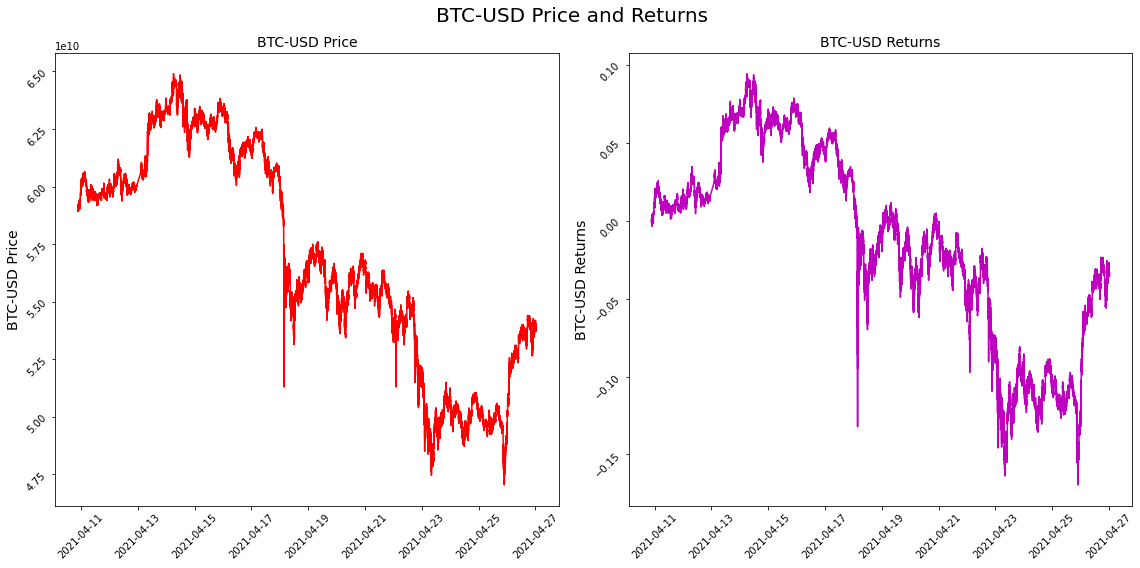

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
BTC-USD Statistics,-0.035553,0.346881,-0.102494,9.853294,-0.024737,-0.00025,-0.27512


In [10]:
pair_prices('trades_narrow_BTC-USD_2021','BTC-USD')

<b> Observation :</b> We observe sharp price movements in the BTC/USD returns in the given time period from April 11 to April 27. The fall is much sharper on around April 18 with a quick recovery. It would be interesting to analyze how the flow bets would work during such directional movements. 

### Regressing Returns on Flows
We begin with default $\tau$ = 30 seconds and $T$ = 10 seconds

In [11]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_BTC-USD_2021','trades_narrow_BTC-USD_2021')

                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              272.6
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                    3.50e-61
Time:                        22:29:42   Log-Likelihood:                      9.6530e+05
No. Observations:              149221   AIC:                                 -1.931e+06
Df Residuals:                  149220   BIC:                                 -1.931e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations from Regression results: </b>
1. The $R^2$ of 0.002 is low but shows some explainability of future returns comes from the Volume Flow series
2.  The <b> Flow Beta </b> has a very high t-stat indicating very strong significance of the Regression Coefficient. <b>This proves that the regression coefficient could be relied upon to predict future returns. </b>

Overall, for such a large dataset, a significant regression coefficient is good indicator of possible profitability from trading.

### Optimizing j for triggering trades

As defined in the objective, we need to define a threshold parameter $j$ such that we could trade when our absolute predicted returns are more than $j$. The number of trades we could end up doing depends on the choice of this $j$. <b> We try optimizing the value of $j$ in such a way that we capture about 1 to 5% of available trading opportunites. </b> We start by computing this Trading Opportunities Captured metric for different values of $j$.

In [12]:
optimizeJ(trainStrategy)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
0.00001,30415.0,10810.0,107996.0,27.63
0.00002,12768.0,5743.0,130710.0,12.41
0.00003,6364.0,3291.0,139566.0,6.47
0.00004,4306.0,1858.0,143057.0,4.13
0.00005,2178.0,1302.0,145741.0,2.33
0.00006,1195.0,956.0,147070.0,1.44
0.00007,601.0,776.0,147844.0,0.92
0.00008,211.0,560.0,148450.0,0.52
0.00009,41.0,330.0,148850.0,0.25


To have a hit rate in about 1% to 5% of trading time, we shall choose j between 0.00004 and 0.00007

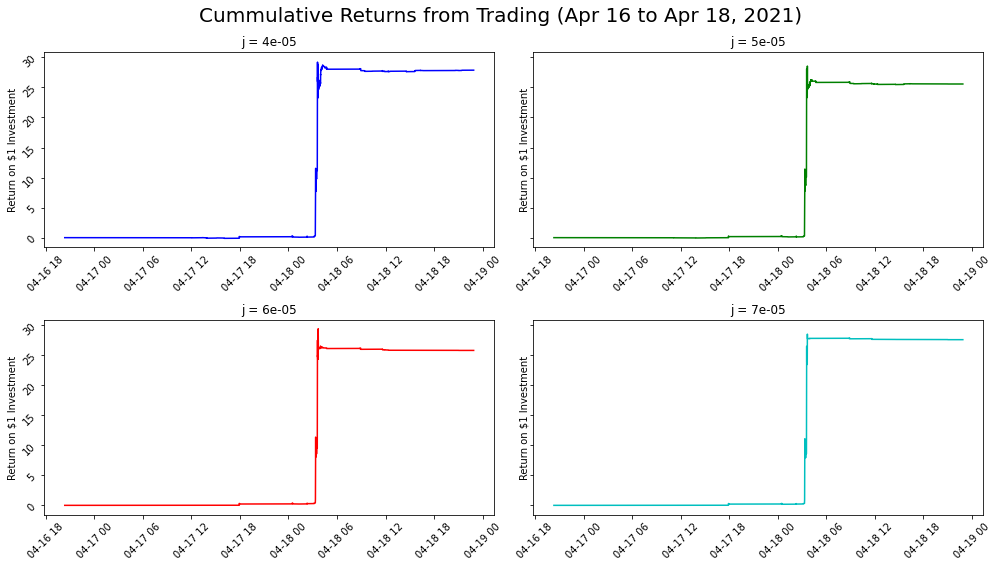

In [13]:
jTry = [0.00004, 0.00005, 0.00006, 0.00007]
returns = cummulativeReturnsPlot(testStrategy,jTry,'Cummulative Returns from Trading (Apr 16 to Apr 18, 2021)')

In [14]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 4e-05,27.867916,0.597083,46.673449,3.041714,-0.019788,-0.002012,-0.997464
For j = 5e-05,25.567334,0.567794,45.029258,3.462556,-0.019788,-0.002293,-0.991832
For j = 6e-05,25.781113,0.538766,47.852175,4.139918,-0.019788,-0.002701,-0.973012
For j = 7e-05,27.568357,0.516600,53.364988,5.088616,-0.019788,-0.002801,-0.957817


<b> Obsevations on broad strategy implementation: </b> 

- We observe a huge spike in the return series in the early morning of April 18th. 
- In each of the cases, our strategy returns became multi-fold in a very short time window. 
- <b> The scale of the spike was so large that we are unable to analyze the performance of the strategy in the remaining time period. </b>
- Of course, in reality, we may not be able to place trades at such high frequency during a very volatile period. We thus try to analyze the possible reasons for such a spike. 

We start by analyzing the price of the underlying security, Bitcoin-USD during this time period.

### Bitcoin-USD prices - the morning of April 18, 2021

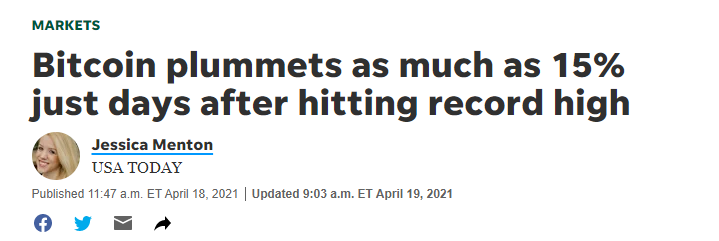

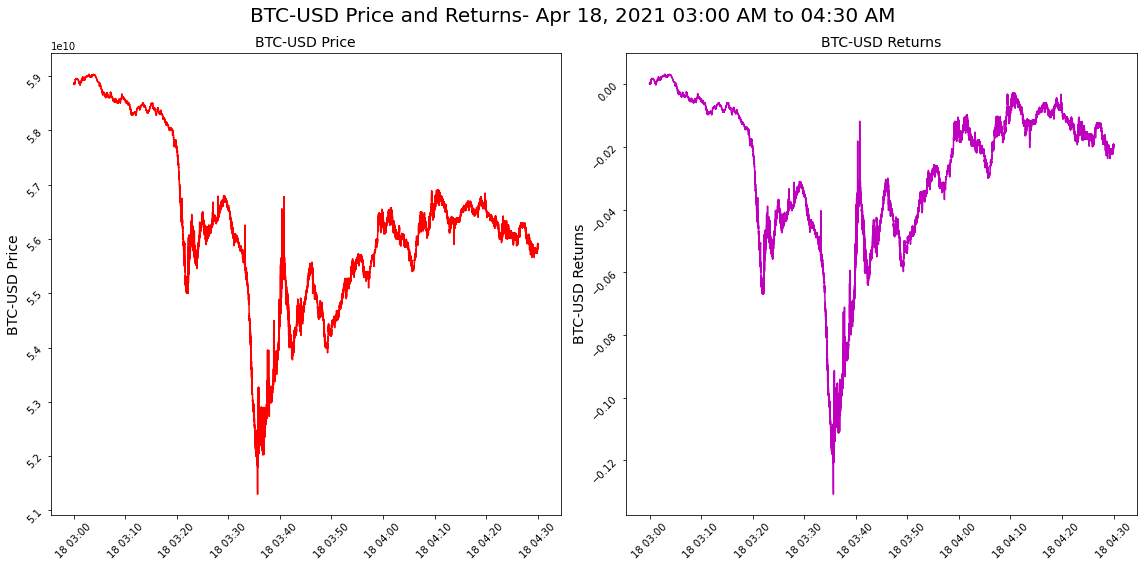

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
BTC-USD Statistics,-0.019272,0.253053,-0.076158,-1.835984,-0.024737,-0.001389,-0.131051


In [15]:
pair_prices('trades_narrow_BTC-USD_2021','BTC-USD','2021-04-18 03:00:00','2021-04-18 04:30:00','- Apr 18, 2021 03:00 AM to 04:30 AM')

<b> Observation on BTC-USD Price series: </b> We observe the Bitcoin prices fell by almost 13% within a span of 30 minutes and then recovered back most of the losses in the next 30 minutes to settle at about a 3% price fall. This extreme volatility must be the cause of the spike in our strategy returns. 

Furthermore, the bulk of the rapid change in prices came only during the period from 03:15 AM to 04:15 AM. Next, we try analyzing how our strategy would have performed assuming no trading in this time window. 

<b> We modify our trading behavior to not trade during this extremely volatile hour. </b> This would allow us to study the performance of our Flow strategy without this outlier event.

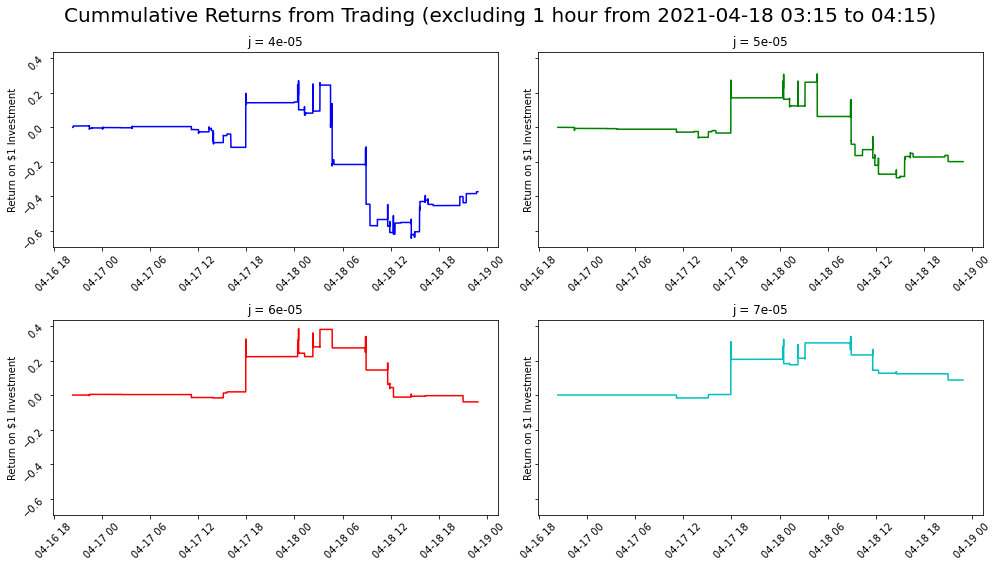

In [16]:
#We remove the very volatile time period from 03:15 AM to 04:15 AM on April 18, 2021 from our strategy
testStrategySubSet = testStrategy[:'2021-04-18 03:15'].append(testStrategy['2021-04-18 04:15':])
returns = cummulativeReturnsPlot(testStrategySubSet,jTry,\
                       'Cummulative Returns from Trading (excluding 1 hour from 2021-04-18 03:15 to 04:15)')

In [17]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 4e-05,-0.372885,0.082131,-4.540108,-5.113583,-0.003910,-0.000781,-0.599737
For j = 5e-05,-0.198585,0.067662,-2.934956,-5.718918,-0.003910,-0.000863,-0.452722
For j = 6e-05,-0.039710,0.054885,-0.723516,-7.778636,-0.003910,-0.000871,-0.346014
For j = 7e-05,0.086893,0.046145,1.883068,-2.136140,-0.003226,-0.000800,-0.222955


<b> Observations on trading during non-directional flows: </b> 
- The strategy are mostly non-profitable as we observe almost negligble returns for all the choosen j sizes. Note that the constructed subset is instelf composed of more than 500,000 trading opportunity points and is thus sufficently large. Yet the strategy did not show any clear profitable opportunity

<b> Conclusion: </b>
- The flow based strategy could provide extraordinary returns in times of great unidirectional price flows. However such strateges may not be able to generate profits when the markets are moving sideways without any clear Flow Trade direction.

<b> Next, we attempt to scale down our trading during this volatile period </b>

Next, we try to create a trading strategy that can do some trading in the high volatility period from 03:15 AM to 04:15 AM and see how such a strategy could work. We assume here that we only trade at the 20th available opportunity to trade during this period and thus <b> use a scaling factor of 30 </b>.

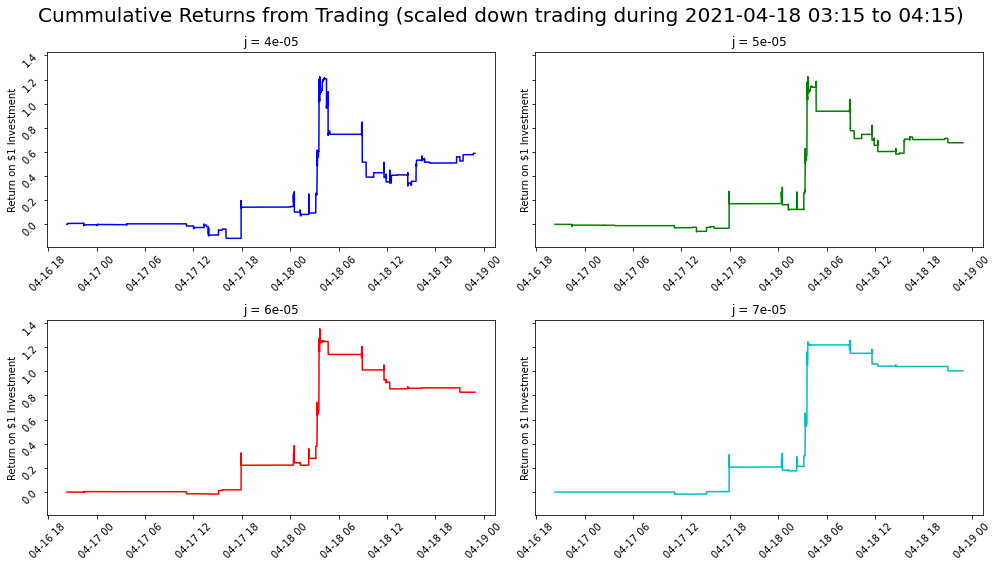

In [18]:
scale = 30

testStrategyScaled = testStrategy.loc[:'2021-04-18 03:15'].copy()
for i in range(0,len(testStrategy['2021-04-18 03:15':'2021-04-18 04:15']),scale):
    testStrategyScaled = testStrategyScaled.append(testStrategy['2021-04-18 03:15':'2021-04-18 04:15'].iloc[i])
testStrategyScaled = testStrategyScaled.append(testStrategy.loc['2021-04-18 04:15':])

returns = cummulativeReturnsPlot(testStrategyScaled,jTry,\
                        'Cummulative Returns from Trading (scaled down trading during 2021-04-18 03:15 to 04:15)')

<b> Observations on scaled down trading implementation: </b> Now we get to see  our strategy in action, with higher profitability in highly volatile time period. This should be closer to realistic trading opportunities in the BTC-USD market as we are injecting very few trades (only about 1 in 30) during a strong directional flow event. Even with such limited trading, we can generate health returns over our initial investment of $1. <b> We could conclude that our trading strategy could be relied to provide excellent returns during large directional moves while staying largely neutral during non-directional market flows.
</b>

<u> Considering this model is most practical in terms of undertaking trades even during very volatile time periods, we shall use this as the benchmark for our BTC-USD trading implementations </u>

In [19]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 4e-05,0.588256,0.136928,4.296116,7.032817,-0.018799,-0.000910,-0.596757
For j = 5e-05,0.675913,0.123780,5.460586,9.605100,-0.018799,-0.001040,-0.474304
For j = 6e-05,0.827134,0.112811,7.332040,13.021375,-0.018799,-0.001089,-0.409448
For j = 7e-05,1.004019,0.105297,9.535156,18.416597,-0.018799,-0.001005,-0.222955


<b> Observation on the choice of $j$ :</b> We note that a relatively large value of $j$ gave the best possible returns of almost 100% during the short 2 day trading window. As expected, this position is the least volatile as well since we only trade at a very strong signal. This higher threshold would be also most profitable in terms of having the least trading costs. We shall continue observing the trends of returns based on $j$.

### Changing $\tau$ and $T$

We modify the choosen parameters of $\tau$ and $T$ and observe the behavior of our flow trading implementation

### Iteration 1: $\tau$ = 20 seconds, $T$ = 20 seconds

In [20]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_BTC-USD_2021','trades_narrow_BTC-USD_2021',\
                                            tauSeconds=20,TSeconds = 20)

                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              453.2
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                   2.04e-100
Time:                        22:30:25   Log-Likelihood:                      9.1077e+05
No. Observations:              149221   AIC:                                 -1.822e+06
Df Residuals:                  149220   BIC:                                 -1.822e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations from Regression Results </b>
- The $R^2$ has improved from 0.002 to 0.003 indicating better explainatory power
- the t-statistic is also larger and thus we can rely on the Regression Flow coefficient to undertake trading

We again try finding the optimal $j$ value for this set of $\tau$ and $T$

In [21]:
optimizeJ(trainStrategy,scale = 0.00002)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
0.00002,26798.0,10582.0,111841.0,25.05
0.00004,11074.0,4913.0,133234.0,10.71
0.00006,5788.0,2911.0,140522.0,5.83
0.00008,3187.0,1612.0,144422.0,3.22
0.00010,1488.0,1105.0,146628.0,1.74
0.00012,949.0,821.0,147451.0,1.19
0.00014,328.0,634.0,148259.0,0.64
0.00016,58.0,464.0,148699.0,0.35
0.00018,0.0,296.0,148925.0,0.20


Now to capture 1 to 5% of the trading opportunites, we choose j between 0.0006 and 0.00012

In [22]:
jTry = [0.00006,0.00008,0.00010,0.00012]

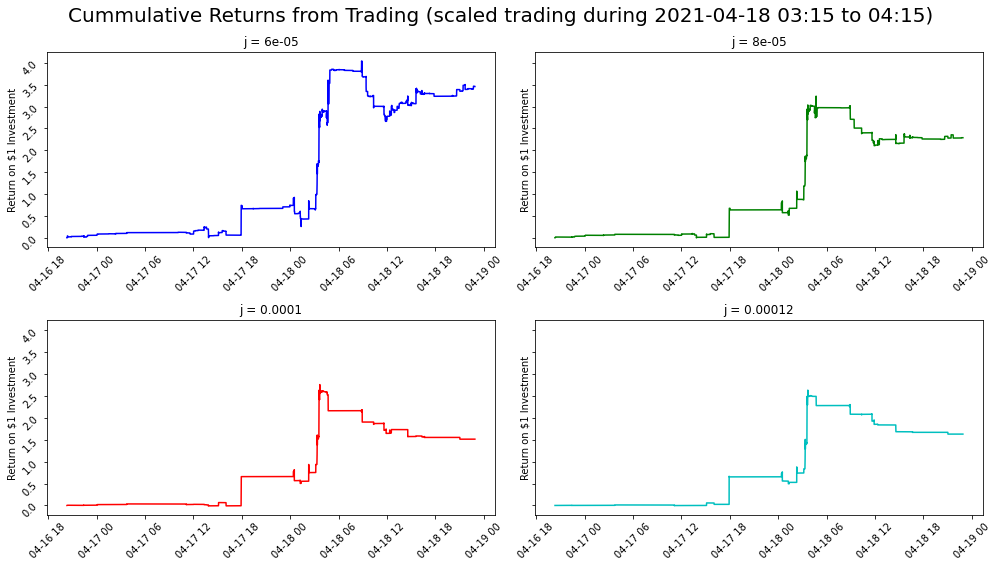

In [23]:
scale = 30

testStrategyScaled = testStrategy.loc[:'2021-04-18 03:15'].copy()
for i in range(0,len(testStrategy['2021-04-18 03:15':'2021-04-18 04:15']),scale):
    testStrategyScaled = testStrategyScaled.append(testStrategy['2021-04-18 03:15':'2021-04-18 04:15'].iloc[i])
testStrategyScaled = testStrategyScaled.append(testStrategy.loc['2021-04-18 04:15':])

testStrategyScaledReturns = cummulativeReturnsPlot(testStrategyScaled,jTry,\
                        'Cummulative Returns from Trading (scaled trading during 2021-04-18 03:15 to 04:15)')

In [24]:
summaryStats(testStrategyScaledReturns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 6e-05,3.456474,0.249969,13.827626,12.155300,-0.022292,-0.001031,-0.748732
For j = 8e-05,2.286587,0.217937,10.491954,17.103217,-0.022292,-0.001197,-0.678121
For j = 0.0001,1.515379,0.196153,7.725500,21.971625,-0.022292,-0.001340,-0.713745
For j = 0.00012,1.630931,0.186646,8.738077,25.681510,-0.022292,-0.001405,-0.634565


<b> Observations from Cummulative Returns: </b> We note that reducing $\tau$ and increasing $T$ has enhanced our returns substantially to about 200 to 300% of initial capital. We also note that our strategy generates some more postive returns at multiple time periods. <b> Thus we hypothesize that acting on shorter term volume flow information and holding the positions for longer time horizon could be more profitable. </b>

<b> Observations on the choice of $j$ : </b> This time, the returns are flipped with respect to $j$ with best returns coming from smaller value of j. In this case, we are able to profitably capture a lot more trades from our strategy. 

### Iteration 2 : $\tau$ = 10 seconds, $T$ = 20 seconds
Next, to further check our hypothesis, we reduce our $\tau$ further to 10 seconds while keeping the holding period $T$ at 20 seconds.

In [25]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_BTC-USD_2021','trades_narrow_BTC-USD_2021',\
                                            tauSeconds=10,TSeconds = 20)

                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              592.0
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                   1.67e-130
Time:                        22:30:59   Log-Likelihood:                      9.1084e+05
No. Observations:              149221   AIC:                                 -1.822e+06
Df Residuals:                  149220   BIC:                                 -1.822e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations: </b> We see a furhter enhancement in $R^2$ to 0.004 and even more significant Flow coefficient with a t-statistic of 24.33. This model demonstrates very strong linear relationship between Flow and Returns.

In [26]:
optimizeJ(trainStrategy,0.00002)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
0.00002,26258.0,11787.0,111176.0,25.50
0.00004,13212.0,5721.0,130288.0,12.69
0.00006,7346.0,3252.0,138623.0,7.10
0.00008,3783.0,2022.0,143416.0,3.89
0.00010,2289.0,1506.0,145426.0,2.54
0.00012,1329.0,1112.0,146780.0,1.64
0.00014,787.0,725.0,147709.0,1.01
0.00016,279.0,432.0,148510.0,0.48
0.00018,119.0,338.0,148764.0,0.31


In [27]:
jTry = [0.00008,0.00010,0.00012,0.00014]

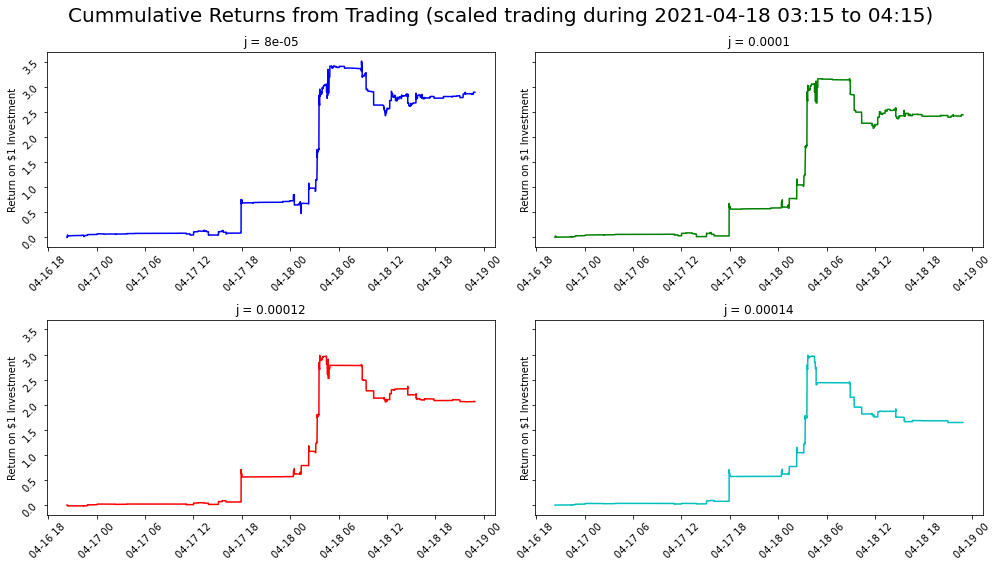

In [28]:
scale = 30

testStrategyScaled = testStrategy.loc[:'2021-04-18 03:15'].copy()
for i in range(0,len(testStrategy['2021-04-18 03:15':'2021-04-18 04:15']),scale):
    testStrategyScaled = testStrategyScaled.append(testStrategy['2021-04-18 03:15':'2021-04-18 04:15'].iloc[i])
testStrategyScaled = testStrategyScaled.append(testStrategy.loc['2021-04-18 04:15':])

testStrategyScaledReturns = cummulativeReturnsPlot(testStrategyScaled,jTry,\
                        'Cummulative Returns from Trading (scaled trading during 2021-04-18 03:15 to 04:15)')

In [29]:
summaryStats(testStrategyScaledReturns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 8e-05,2.891174,0.229344,12.606283,15.101853,-0.022292,-0.001063,-0.664086
For j = 0.0001,2.442439,0.211258,11.561422,19.036053,-0.022292,-0.001164,-0.628724
For j = 0.00012,2.061963,0.196778,10.478615,22.701347,-0.022292,-0.001288,-0.605646
For j = 0.00014,1.645671,0.183364,8.974869,28.227637,-0.014990,-0.001401,-0.738958


<b> Observations from Cummulative Returns: </b> The returns have reduced slightly with respect to Iteration 1 and thus we may argue that reducing $\tau$ is no longer helpful.

<b> Observations on the choice of $j$ : </b> Again, the returns are flipped with respect to $j$ with best returns coming from smaller value of j. We could thus leave the exact choice of $j$ parameter <b>  inconclusive </b> as of now for BTC-USD.

### Conclusions: BTC/USD Trade Flows
1. <b> Regression Coefficient </b> We observe all the strategies generate <u> highly significant Regression coefficient for Flow </u> parameter indicating genuine trading opportunity in the BTC-USD Trade Flows
2. <b> Regression $R^2$ </b> Regression $R^2$ in the range of 0.2% to 0.4% shows some explainability of Flow factor, however a large part of the returns stay unexlained.
3. <b> $\tau$ and $T$ </b> After trying different values of the parameters $\tau$ and $T$, we note that taking $\tau$ = 20 seconds and $T$ = 20 seconds generated most significant returns. <u> This indicates the approximate time it would take for flow information to get priced in to the market. </u>
4. <b> $j$ </b> We saw conflicting trends in returns from increasing the threshold j. <u> Considering without taking any trading constraints, the choice of $j$ is non-conclusive, we should rather make the choice of $j$ on the basis of trading costs and frequencies. </u>

## Section B: ETH-USD
We again begin by analyzing the ETH-USD price and returns series.

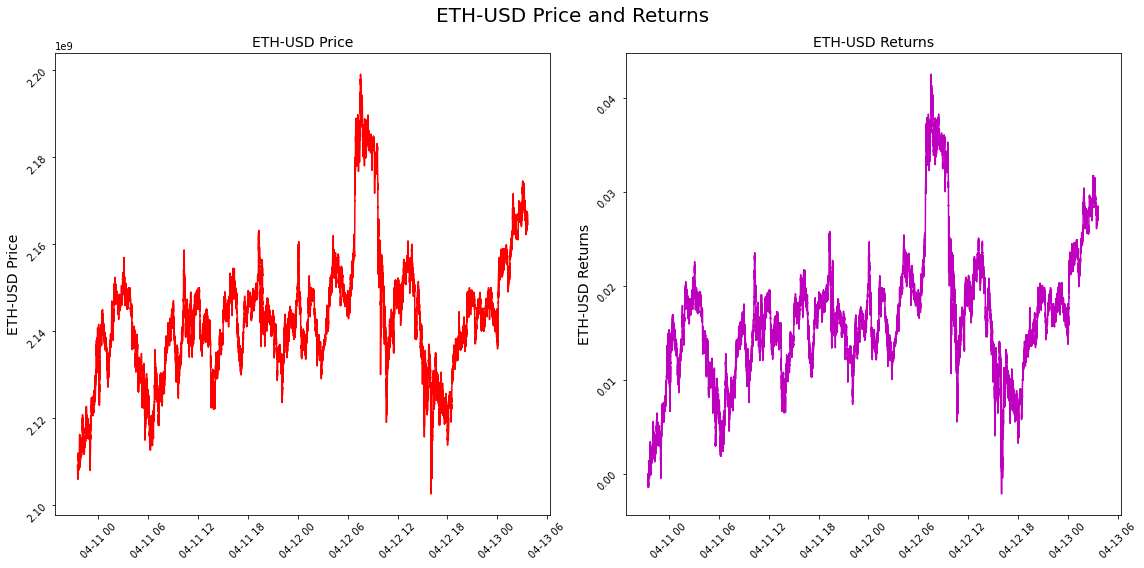

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
ETH-USD Statistics,0.02712,0.04841,0.5602,0.525169,-0.002282,-0.000223,-0.043909


In [30]:
pair_prices('trades_narrow_ETH-USD_2021','ETH-USD')

<b> Observations: </b> Unlike BTC-USD, the ETH-USD series is less volatile. Note that this is a different trading window from April 11 2021 to April 13 2021. This should be a good training ground to test our flow strategy in a low price movement environment.

<b> Regressing Flows on Returns </b>

We again begin with $\tau$ = 30 seconds and $T$ = 10 seconds to build our model

In [31]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_ETH-USD_2021','trades_narrow_ETH-USD_2021')

                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              25.69
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                    4.02e-07
Time:                        22:31:23   Log-Likelihood:                      2.4848e+05
No. Observations:               37732   AIC:                                 -4.970e+05
Df Residuals:                   37731   BIC:                                 -4.970e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations from Regression results: </b> 
1. The Regression $R^2$ of 0.001 is less than what we observed in BTC-USD trades. Thus the flow factor may not be able to explain as much of retruns and we may expect more idiosyncrasies here
2. The Flow coefficient is still signficant and thus could be reliably used in a trading strategy. Howerver, the t-statistic is much worse than what we observer in BTC-USD trades. 

We again optimize the choice of $j$ to implement our trading strategy

In [32]:
optimizeJ(trainStrategy)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
0.00001,1178.0,2452.0,34102.0,9.62
0.00002,369.0,972.0,36391.0,3.55
0.00003,216.0,616.0,36900.0,2.21
0.00004,133.0,338.0,37261.0,1.25
0.00005,57.0,212.0,37463.0,0.71
0.00006,37.0,44.0,37651.0,0.21
0.00007,0.0,2.0,37730.0,0.01
0.00008,0.0,0.0,37732.0,0.00
0.00009,0.0,0.0,37732.0,0.00


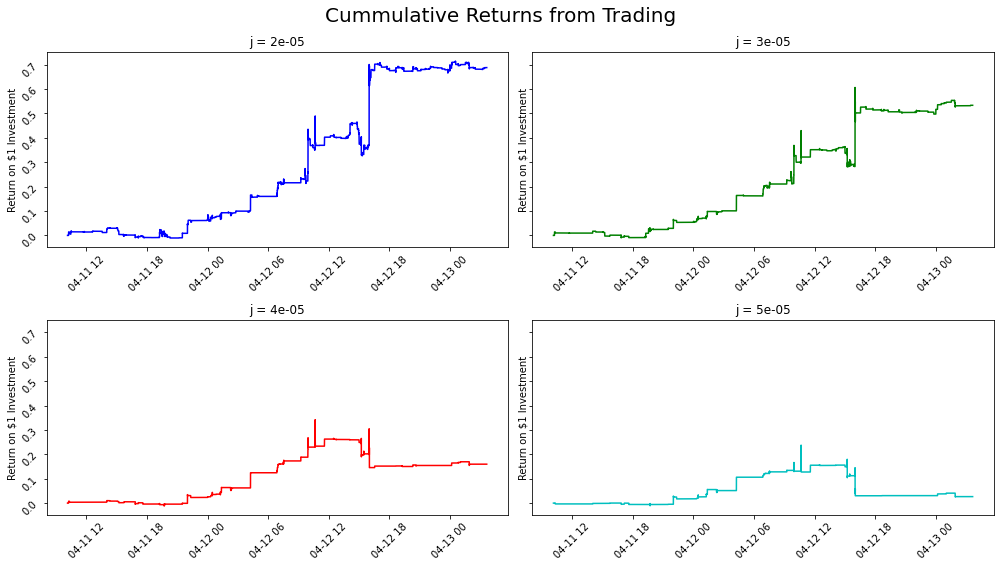

In [33]:
jTry = [0.00002,0.00003,0.00004,0.00005]
returns = cummulativeReturnsPlot(testStrategy,jTry,'Cummulative Returns from Trading')

In [34]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 2e-05,0.687834,0.069398,9.911487,5.945797,-0.004458,-0.000417,-0.150962
For j = 3e-05,0.533328,0.061752,8.636553,7.941771,-0.004458,-0.000490,-0.138626
For j = 4e-05,0.159632,0.044730,3.568830,-3.200149,-0.004458,-0.000566,-0.178953
For j = 5e-05,0.026656,0.037835,0.704539,-10.088263,-0.004458,-0.000667,-0.191270


<b> Observations from Cummulative Returns: </b> The returns are mostly positive with low volatility. This is good from a strategy reliability perspective.

<b> Observations on the choice of $j$ : </b> The profitability from choosing a small $j$ are significantly larger than choosing a bigger $j$. Thus there is high profitability from entering multiple trades for smaller expected profits. 

### Changing $\tau$ and $T$
Next, we try using $\tau$ = 20 seconds, $T$ = 20 seconds. These were the best fitting parameters for BTC-USD trades

In [35]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_ETH-USD_2021','trades_narrow_ETH-USD_2021',\
                                            tauSeconds = 20,TSeconds = 20)

                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              6.447
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                      0.0111
Time:                        22:31:31   Log-Likelihood:                      2.3624e+05
No. Observations:               37732   AIC:                                 -4.725e+05
Df Residuals:                   37731   BIC:                                 -4.725e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations from Regression: </b> 
- The Regression $R^2$ has gone down to negligible and the Flow coefficient, even though still significant, has a much smaller t-statistic
- Thus the model is less reliable now. We may assume that a longer holding period may be more beneficial for ETH-USD trades.
- <u> Note: </u> The number of observations for ETH-USD trades is much smaller, about 38 thousand in traing data set as compared to about 150 thousand for BTC-USD. We may get more reliable regression results from having longer training datasets.

In [36]:
optimizeJ(trainStrategy,scale = 0.000003)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
0.000003,3608.0,4208.0,29916.0,20.71
0.000006,1420.0,2449.0,33863.0,10.25
0.000009,763.0,1591.0,35378.0,6.24
0.000012,533.0,1124.0,36075.0,4.39
0.000015,340.0,845.0,36547.0,3.14
0.000018,231.0,606.0,36895.0,2.22
0.000021,172.0,526.0,37034.0,1.85
0.000024,150.0,461.0,37121.0,1.62
0.000027,126.0,363.0,37243.0,1.30


As the ETH-USD market is less liquid, let us try capturing a bigger share of the trades (3% to 10%) here

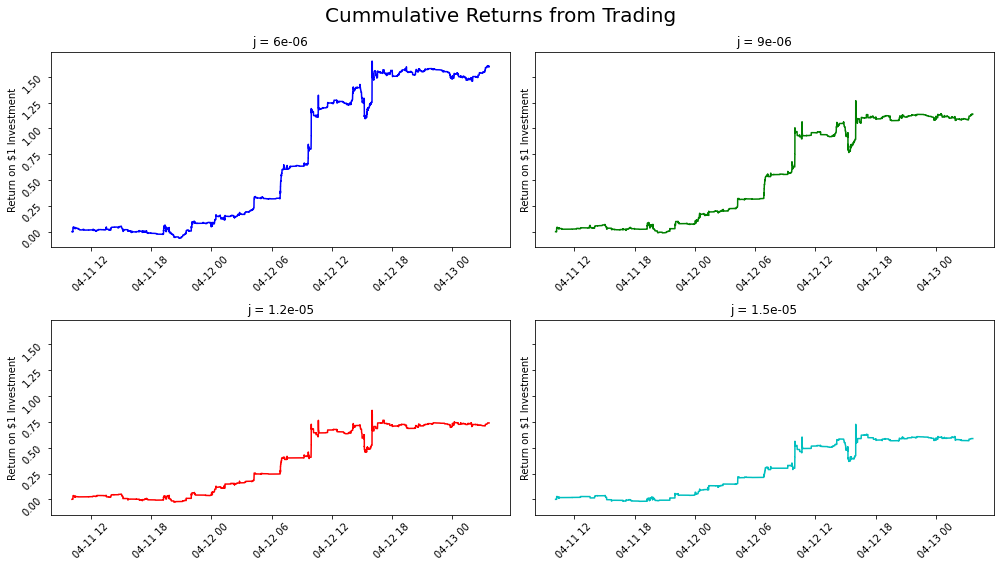

In [37]:
jTry = [0.000006,0.000009,0.000012,0.000015]
returns = cummulativeReturnsPlot(testStrategy,jTry,'Cummulative Returns from Trading')

In [38]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 6e-06,1.600861,0.107030,14.957187,3.884489,-0.004504,-0.000544,-0.283134
For j = 9e-06,1.137505,0.094664,12.016256,5.001535,-0.004504,-0.000489,-0.258235
For j = 1.2e-05,0.739888,0.086266,8.576823,5.447648,-0.004504,-0.000534,-0.266465
For j = 1.5e-05,0.588535,0.078688,7.479368,5.579339,-0.004504,-0.000558,-0.211070


<b> Observations from Cummulative Returns: </b> Intrestingly, the returns are substantially higher for this choice of $\tau$ and $T$. <b> Since the Regressions summaries were worse than the previous iteration of $\tau$ and $T$, we may attribute these higher returns to luck rather than systematic trading. </b>

<b> Observations on the choice of $j$ : </b> Again, the profitability from choosing a small $j$ are significantly larger than choosing a bigger $j$. Thus there is high profitability from entering multiple trades for smaller expected profits. 

### Conclusions: ETH/USD Trade Flows
1. <b> Regression Coefficient </b> We again observe that the strategies generate <u> significant Regression coefficient for Flow </u> parameter indicating genuine trading opportunity in the ETH-USD Trade Flows
2. <b> Regression $R^2$ </b> Regression $R^2$ in the range of 0% to 0.1% shows limited explainability of Flow factor, and a large part of the returns stay unexlained.
3. <b> $\tau$ and $T$ </b> the parameters $\tau$ and $T$, could be tuned to fit the training data set better. But it may not provide significant explainability on the test set.
4. <b> $j$ </b> A smaller value of $j$ is better at generating higher returns for ETH-USD. Thus we can profitably enter multiple  low return trades (penny picking) trading in ETH-USD
5. Considering less liquidiy in ETH USD as compared to BTC USD, we may widen the training data set to get better predictive models

Overall, the strategies showed good profitability making a strong case for exploring Trade Flow opportunities in ETH-USD markets.

## Section C: ETH BTC
First, we analyze the ETH-USD price and returns trend.

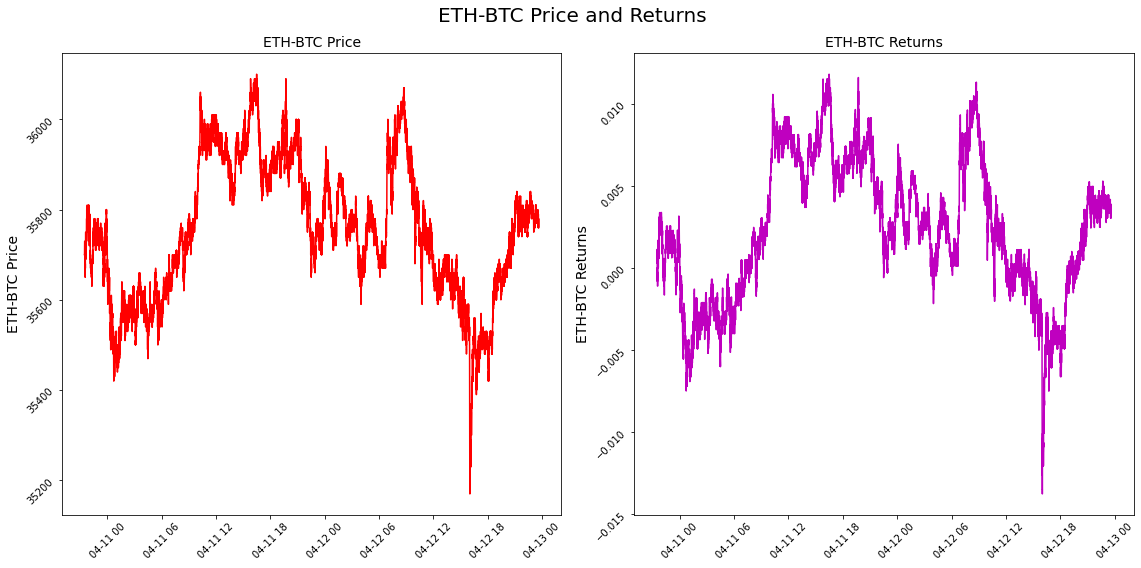

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
ETH-BTC Statistics,0.003048,0.046669,0.065319,0.088388,-0.001134,-0.000528,-0.025762


In [39]:
pair_prices('trades_narrow_ETH-BTC_2021','ETH-BTC')

<b> Observations </b> ETH-BTC series is quite stationary over the 2 day time period from April 11 to April 13, 2021. It would be again interesting to observe Trade Flow opportunities in this market.

<b> Regressing Flows on Returns </b>

In [40]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_ETH-BTC_2021','trades_narrow_ETH-BTC_2021')


                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                           0.002116
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                       0.963
Time:                        22:31:34   Log-Likelihood:                          30856.
No. Observations:                4566   AIC:                                 -6.171e+04
Df Residuals:                    4565   BIC:                                 -6.170e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations :</b> With an $R^2$ of zero along with non-significant value of the Flow coefficient, we do not expect the Trade Flows to have much predicitve power. Again note that we are using a much smaller training dataset of only about 4500 trades.

We again try optimizing $j$ for our trading analysis

In [41]:
optimizeJ(trainStrategy,0.0000001)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
1.000000e-07,537.0,344.0,3685.0,19.29
2.000000e-07,295.0,199.0,4072.0,10.82
3.000000e-07,190.0,147.0,4229.0,7.38
4.000000e-07,128.0,94.0,4344.0,4.86
5.000000e-07,86.0,73.0,4407.0,3.48
6.000000e-07,66.0,48.0,4452.0,2.50
7.000000e-07,36.0,39.0,4491.0,1.64
8.000000e-07,22.0,26.0,4518.0,1.05
9.000000e-07,17.0,15.0,4534.0,0.70


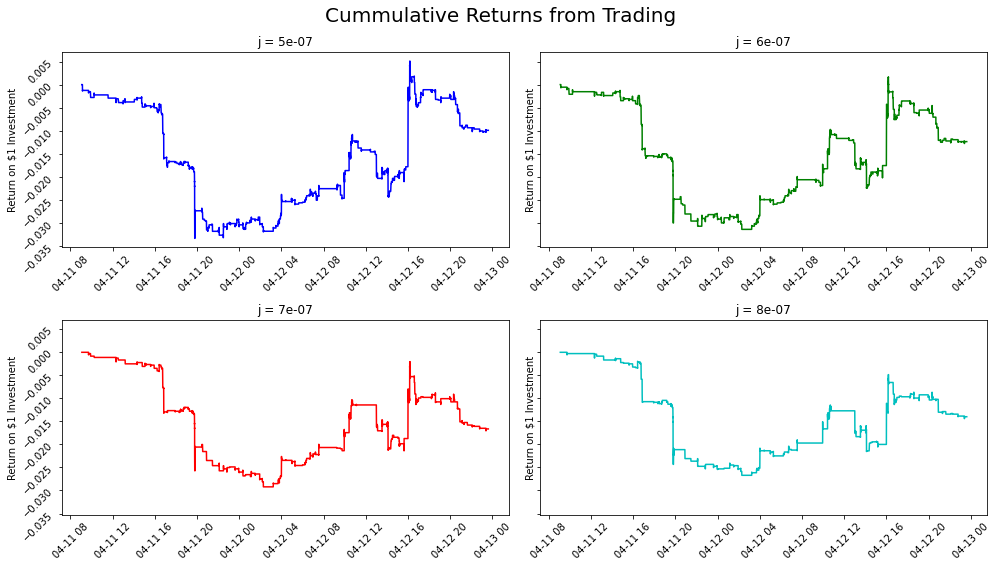

In [42]:
jTry = [5.000000e-07,6.000000e-07,7.000000e-07,8.000000e-07]
returns = cummulativeReturnsPlot(testStrategy,jTry,'Cummulative Returns from Trading')

In [43]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 5e-07,-0.009931,0.012862,-0.772096,0.022938,-0.001846,-0.000270,-0.032843
For j = 6e-07,-0.012378,0.011856,-1.044034,-0.574302,-0.001846,-0.000280,-0.030962
For j = 7e-07,-0.016635,0.011035,-1.507551,-1.180819,-0.001846,-0.000292,-0.028806
For j = 8e-07,-0.013986,0.010012,-1.396825,-2.362474,-0.001846,-0.000305,-0.026367


<b> Observations from Cummulative Returns: </b> We see small negative returns for each of the choosen strategy. This  may be expected as our Regression model itself lacks predictive strength.

<b> Observations on the choice of $j$ : </b> There is no clear trend in the returns again indicating low model predicitve strength. 

## Changing $\tau$ and T

Since we were unable to generate significant results with $\tau$ of 30 seconds, let us try increasing it to 60 seconds to see if longer time horizon could help in prediction. We also increase $T$ to 20 seconds.

<b> Regressing Flows on Returns </b>

In [44]:
trainStrategy, testStrategy = analyzeTrades('book_narrow_ETH-BTC_2021','trades_narrow_ETH-BTC_2021',\
                                            tauSeconds = 60,TSeconds = 20)

                                 OLS Regression Results                                
Dep. Variable:              logReturn   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.2220
Date:                Sat, 12 Feb 2022   Prob (F-statistic):                       0.638
Time:                        22:31:37   Log-Likelihood:                          29981.
No. Observations:                4566   AIC:                                 -5.996e+04
Df Residuals:                    4565   BIC:                                 -5.995e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<b> Observations :</b> Even with $\tau$ = 60 seconds, the model has zero $R^2$ and insignficant Flow coefficient. Thus we do not expect good predictive strength in the model. 

Optimizing the parameter $j$

In [45]:
optimizeJ(trainStrategy,scale = 0.000001)

,#Buys,#Sells,#No Trades,Trading Opportunities Captured(%)
j,,,,
0.000001,781.0,477.0,3308.0,27.55
0.000002,448.0,293.0,3825.0,16.23
0.000003,289.0,184.0,4093.0,10.36
0.000004,199.0,127.0,4240.0,7.14
0.000005,136.0,92.0,4338.0,4.99
0.000006,79.0,82.0,4405.0,3.53
0.000007,45.0,60.0,4461.0,2.30
0.000008,40.0,43.0,4483.0,1.82
0.000009,30.0,40.0,4496.0,1.53


Again trying to capture more trades in an illiquid market.

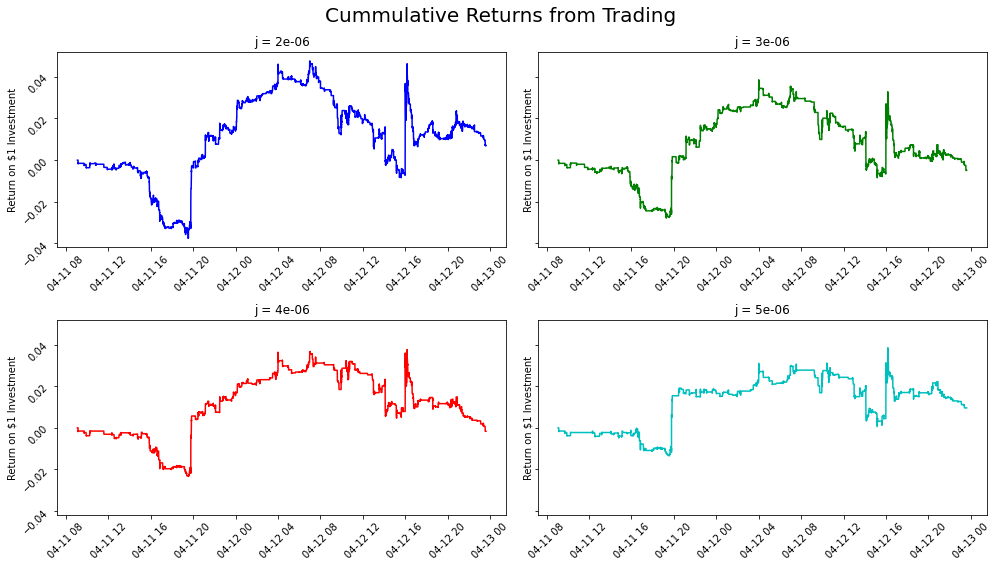

In [46]:
jTry = [0.000002,0.000003,0.000004,0.000005]
returns = cummulativeReturnsPlot(testStrategy,jTry,'Cummulative Returns from Trading')

In [47]:
summaryStats(returns)

,Period Return,Volatility,Sharpe Ratio,Skewness,min return,Expected Shortfall (95% VaR),Maximum Drawdown
For j = 2e-06,0.006977,0.026839,0.259966,1.774628,-0.002129,-0.000518,-0.054567
For j = 3e-06,-0.004913,0.023281,-0.211038,1.168852,-0.002129,-0.000432,-0.046018
For j = 4e-06,-0.001653,0.021271,-0.077727,1.247140,-0.002129,-0.000380,-0.038520
For j = 5e-06,0.009565,0.019362,0.494005,1.925258,-0.001835,-0.000334,-0.030016


<b> Observations from Cummulative Returns: </b> We again see small negative returns for each of the choosen strategy. This  may be expected as our Regression model itself lacks predictive strength.

<b> Observations on the choice of $j$ : </b> There is no clear trend in the returns again indicating low model predicitve strength. 

### Conclusions: ETH/BTC Trade Flows
1. <b> Regression Coefficient </b> Regression coefficients were insignificant indicating poor predictive strength from Regression model
2. <b> Regression $R^2$ </b> Regression $R^2$ of close to zero again indicates poor explainability of price variations from Flow data
3. <b> $\tau$ and $T$ </b> Without a stronger relationship between Flows and Returns, the parameters $\tau$ and $T$, may not be useful in our model 
4. <b> $j$ </b> shows random trends without a strong underlying model
5. Considering low volatility in ETH-BTC market, we try widening the training data set to attempt getting better predictive models

Overall, the strategies did not show profitability making a weak case for exploring Trade Flow opportunities in ETH-BTC markets.

## 4. Conclusions

1. Our Regression model shows:
- Excellent predictive strength for BTC-USD
- Very Good predictive strength for ETH-USD
- Poor predictive strength for ETH-BTC
2. We were able to demonstrate substantial changes in our modeled returns by modifyin $\tau$ and $T$. For BTC-USD, we get best returns for both $\tau$ and $T$ of about 20 seconds. These values could be calibrated over different timeframes and for other currency pairs as well. Fundamentally, these values indicate the time it takes for new information to get priced in to the market. <b> As cryptocurrency markets have extremely quick regime changes, we recommend validating on different values of $\tau$ and $T$ each time while implementing the strategy. </b>
3. We choose the parameter $j$ in such a way that we capture about 1% to 5% of the market trade flows. Beyind this choice, we could not find a very strong relationship between the value of $j$ and strategy returns. Thus we may choose $j$ based on our trading costs and possible trading frequency.
4. The BTC-USD market was the most liquid and had the best predicitve model. We assume that a training set of 20% was sufficient to build a good working model. We may <b> try implementing the model with recurrent learning of the features or rolling Betas </b> to better capture the Flow-return dynamics.
5. The ETH-USD market is relatively less liquid and we could definately benefit from having a larger training data set.
6. As we could not find any predicitve strength in ETH-BTC market, we do not expect such TradeFlow strategies to work in these markets. 
7. For BTC-USD, we saw extreme volatility in the market. Our trading strategies could capture such opportunites very effectively and show extreme profitability. However, the returns from the strategy in other time periods were less impressive. Thus we can use this as a strategy that could generate very large returns at some rare time events and negligible returns with stable risk at most other times. 
8. Overall, we demonstrated empirically provable market based strategy that could be implemented profitably. 